# Predictions with the comparison with baseline

**Update 8/Feb/2021:** adding round 2 result. 

**Update 27/Nov/2020:** kernel normalisation over all 4138 unique sequences. Adjust parameters [centering_flag, unit_norm_flag] for kernel normalisation. 

Update 10/Nov/2020
add Kernel Ridge Regression as a comparison, parameter setting is the same as GPR.

Upate 05/Nov/2020
Update plots for 7 reps for round 1.

Update 29/Oct/2020  
We now have Round 1's results. We observe that the consensus sequence has very different labels for different plates/rounds. So we decide to normalise to the consensus sequence (before log normalisation and z-normalisation, subtract the mean of each consensus sequence mean in each plate/round). We will call the normalisation methods as **plate normalisation** and **round normalisation** respectively.
Let's see how the predictions look like for different normalisation methods on the following training/testing pairs
- train 80% round 0 and test 20% round 0
- train round 0 and test round 1
- train 80% all data (round 0 + 1) and test the rest

As always, we consider GPR with RBF, one-hot as a baseline model we would like to compare with.
Our model GPR with wd kernel with shift.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

import pickle
import xarray

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/admin-u6015325/ownCloud/git/SynbioML/notebooks/result_analysis
['/home/admin-u6015325/ownCloud/git/SynbioML/notebooks/result_analysis', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.5.745244803/pythonFiles', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.5.745244803/pythonFiles', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.5.745244803/pythonFiles/lib/python', '/home/admin-u6015325/anaconda3/lib/python37.zip', '/home/admin-u6015325/anaconda3/lib/python3.7', '/home/admin-u6015325/anaconda3/lib/python3.7/lib-dynload', '', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/strkernel-0.2-py3.7.egg', '/home/admin-u6015325/

## Read Data and Set Up

In [2]:
# plate normalisation
# plateRep_Path = '../../data/Results_Microplate_partialTrue_normTrue_plateRep_formatSeq_logTrue.csv'
# round normalisation

norm_method = 'mean'
log_flag = 'True'
Path = '../../data/pipeline_data/Results_Microplate_partialTrue_normTrue_' + norm_method+ '_roundRep_formatSeq_log' + log_flag + '_Round4.csv'

# plate_df = pd.read_csv(plateRep_Path)
round_df = pd.read_csv(Path)

In [3]:
def run_kfold(df,kernel, embedding, train_idx = None, test_idx = None, 
              num_split = 5,num_repeat = 10,s_list = [1],alpha_list= [2],l_list = [6]):
    gpr = GPR_Predictor(df, train_idx = train_idx, test_idx = test_idx, embedding = embedding, kernel_name = kernel)
    result_DataArray_wd = gpr.Repeated_kfold(num_split=num_split, num_repeat=num_repeat, alpha_list= alpha_list,
                                          l_list = l_list, s_list = s_list)
    # print(result_DataArray_wd[1].mean(axis = -1).mean(axis=-1))
    return result_DataArray_wd

def run_regression(df,kernel, embedding, predictor = GPR_Predictor, train_idx = None, test_idx = None, 
               eva_metric = [mean_squared_error, r2_score], l = 6, s = 1, sigma_0=1, alpha = 2, 
               eva_on='seqs', title = 'Prediction',
               kernel_norm_flag = True, centering_flag = False, unit_norm_flag = True):
    title = title + ' centering' + str(centering_flag) + 'unitnorm' + str(unit_norm_flag)
    # train and test on round 0
    gpr_train_samples = predictor(df, train_idx= train_idx, test_idx=test_idx, kernel_name = kernel,
                kernel_norm_flag = kernel_norm_flag, centering_flag = centering_flag, unit_norm_flag = unit_norm_flag,
                embedding = embedding, eva_metric = eva_metric, l = l, s = s, sigma_0 = sigma_0, alpha = alpha, eva_on=eva_on)
    gpr_train_samples.regression()
    gpr_train_samples.scatter_plot(title = title)
    
    if predictor == GPR_Predictor and kernel == 'WD_Kernel_Shift':
        # gpr_train_samples.line_plot()
        train_df = gpr_train_samples.train_df.drop_duplicates(subset = ['RBS']).reset_index()
        test_df = gpr_train_samples.test_df.drop_duplicates(subset = ['RBS']).reset_index() #.drop(columns = ['level_0'])
        train_df['train_test'] = 'train'
        test_df['train_test'] = 'test'
        train_test_df = pd.concat([train_df, test_df])
        train_test_df = train_test_df.reset_index().drop(['level_0'], axis = 1)
        gpr_train_samples.sort_kernel_label_plot(train_test_df, 
                            # title = 'Data Similarity and Prediction, Sorted by TIR Label', 
                            title = title,
                            group_flag = True)
        # gpr_train_samples.sort_kernel_label_plot(train_test_df, 
        #                     # title = 'Data Similarity and Prediction, Sorted by RBS Similarity', 
        #                     title = title,
        #                     sort_method = 'seq_distance', group_flag = True)
    # else:
    #    gpr_train_samples.scatter_plot(title = title) 



## Train and Test on Round 0 + 1

In [4]:
# # setting

# kernel = 'WD_Kernel_Shift' # 'RBF'
# embedding = 'label' # 'onehot'

# # run_regression(plate_df[plate_df['Plate'] != 'Third_Plate'], kernel, embedding, title = 'Train and Test on Round 0 (WD,plateRep)')
# run_regression(round_df[round_df['Plate'] != 'Fourth_Plate'], kernel, embedding, title = 'Train and Test on Round 0+1 (WD,roundRep)', centering_flag=True, unit_norm_flag=True)
# # run_regression(round_df[round_df['Plate'] != 'Third_Plate'], kernel, embedding, title = 'Train and Test on Round 0 (WD,roundRep)', centering_flag=False, unit_norm_flag=True)
# # run_regression(round_df[round_df['Plate'] != 'Third_Plate'], kernel, embedding, predictor=KRR_Predictor, title = 'Train and Test on Round 0 (WD,roundRep,kRR)')

# kernel = 'RBF'
# embedding = 'onehot'

# # run_regression(plate_df[plate_df['Plate'] != 'Third_Plate'], kernel, embedding, title = 'Train and Test on Round 0 (RBF,plateRep)')
# run_regression(round_df[round_df['Plate'] != 'Fourth_Plate'], kernel, embedding, title = 'Train and Test on Round 0+1 (RBF,roundRep)')

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([265, 266, 268, 269, 270,\n            ...\n            352, 353, 354, 356, 357],\n           dtype='int64', length=74). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

## Train on Round 0+1 and Test on Round 2

X train shape:  (2147, 20)
X test shape:  (93, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
<function mean_squared_error at 0x7f632905bc80>
Train:  0.32710053168230535
Test:  0.33333819478836635
<function r2_score at 0x7f632905bea0>
Train:  0.6305213587142684
Test:  0.6331818120284882
Test pred fit:  [ 0.01687956 -0.65284426]
Test ave fit:  [ 0.03542553 -1.62957438]
coverage rate: 
Train:  0.7708430367955287
Test:  0.7311827956989247


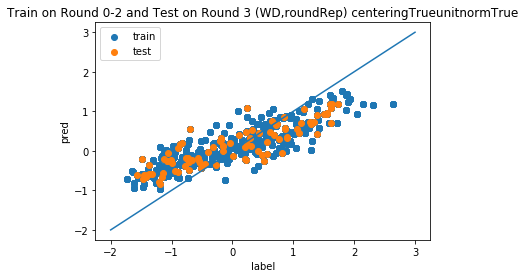

groups:  ['Consensus', 'BPS-C', 'BPS-NC', 'UNI', 'PPM', 'Bandit-0', 'Bandit-1']
/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:716: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)
/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
X train shape:  (2147, 20)
X

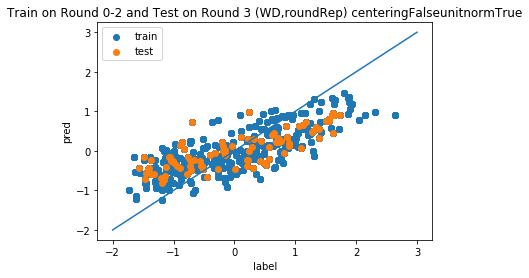

groups:  ['Consensus', 'BPS-C', 'BPS-NC', 'UNI', 'PPM', 'Bandit-0', 'Bandit-1']
/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:716: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)
/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
X train shape:  (2147, 80)
X

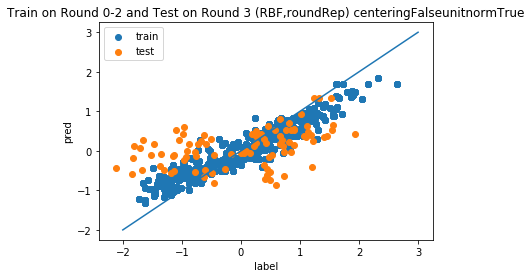

In [6]:
# setting
kernel = 'WD_Kernel_Shift' # 'RBF'
embedding = 'label' # 'onehot'

# run_regression(plate_df, kernel, embedding, train_idx= plate_df['Plate'] != 'Third_Plate', 
#                 test_idx= plate_df['Plate'] == 'Third_Plate', title = ' Train on Round 0 & Test on Round 1 (WD,plateRep)')
run_regression(round_df, kernel, embedding, train_idx= round_df['Plate'] != 'Fifth_Plate', 
                test_idx= round_df['Plate'] == 'Fourth_Plate',  title = 'Train on Round 0-2 and Test on Round 3 (WD,roundRep)',centering_flag=True, unit_norm_flag=True)
run_regression(round_df, kernel, embedding, train_idx= round_df['Plate'] != 'Fifth_Plate', 
                test_idx= round_df['Plate'] == 'Fourth_Plate',  title = 'Train on Round 0-2 and Test on Round 3 (WD,roundRep)',centering_flag=False, unit_norm_flag=True)
# run_regression(round_df, kernel, embedding, train_idx= round_df['Plate'] != 'Third_Plate', 
#                 test_idx= round_df['Plate'] == 'Third_Plate', predictor=KRR_Predictor, title = 'Train on Round 0 and Test on Round 1 (WD,roundRep,KRR)')

kernel = 'RBF'
embedding = 'onehot'

# run_regression(plate_df, kernel, embedding, train_idx= plate_df['Plate'] != 'Third_Plate', 
#                 test_idx= plate_df['Plate'] == 'Third_Plate', title = ' Train on Round 0 & Test on Round 1 (RBF,plateRep)')
run_regression(round_df, kernel, embedding, train_idx= round_df['Plate'] != 'Fifth_Plate', 
                test_idx= round_df['Plate'] == 'Fifth_Plate',  title = 'Train on Round 0-2 and Test on Round 3 (RBF,roundRep)')

# train and test on round 0
# gpr_train_samples = GPR_Predictor(df[df['Plate'] != 'Third_Plate'], kernel_name = kernel, embedding = embedding, eva_metric = eva_metric, l = 6, s = 1, alpha = 2, eva_on='seqs')

# train on round 0 (plate 1 and 2) and test on round 1 (plate 3)
# gpr_train_samples = GPR_Predictor(df, train_idx= df['Plate'] != 'Third_Plate', test_idx= df['Plate'] == 'Third_Plate', 
#                    kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
#                    l = 6, s = 1, alpha = 2, eva_on='seqs')

## Train and Test on All Rounds Data

X train shape:  (1785, 20)
X test shape:  (90, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
<function mean_squared_error at 0x7f632905bc80>
Train:  0.30459397855420484
Test:  1.125897850589704
<function r2_score at 0x7f632905bea0>
Train:  0.6455767553145766
Test:  -0.15882485025212945
Test pred fit:  [0.00343507 0.20595268]
Test ave fit:  [ 0.03703403 -1.76791746]
coverage rate: 
Train:  0.8184873949579832
Test:  0.5777777777777777


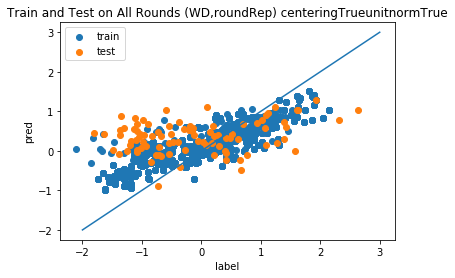

groups:  ['Consensus', 'BPS-C', 'BPS-NC', 'UNI', 'PPM', 'Bandit-0', 'Bandit-1']
/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:716: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)
/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
X train shape:  (1785, 20)
X

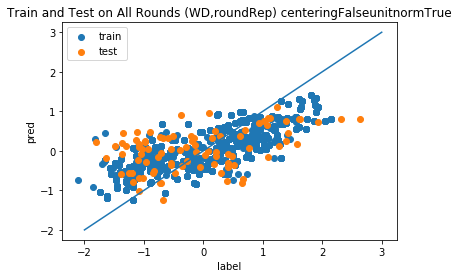

groups:  ['Consensus', 'BPS-C', 'BPS-NC', 'UNI', 'PPM', 'Bandit-0', 'Bandit-1']
/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:716: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)
/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
X train shape:  (1785, 80)
X

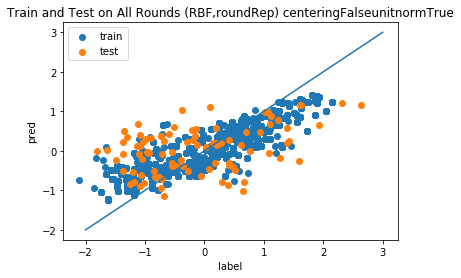

In [5]:
# setting
kernel = 'WD_Kernel_Shift' # 'RBF'
embedding = 'label' # 'onehot'

# run_regression(plate_df, kernel, embedding, title = 'Train and Test on All Rounds (WD,plateRep)')
run_regression(round_df, kernel, embedding, title = 'Train and Test on All Rounds (WD,roundRep)', centering_flag=True, unit_norm_flag=True)
run_regression(round_df, kernel, embedding, title = 'Train and Test on All Rounds (WD,roundRep)', centering_flag=False, unit_norm_flag=True)
# run_regression(round_df, kernel, embedding, predictor=KRR_Predictor, title = 'Train and Test on All Rounds (WD,roundRep,KRR)')

kernel = 'RBF'
embedding = 'onehot'

# run_regression(plate_df, kernel, embedding, title = 'Train and Test on All Rounds (RBF,plateRep)')
run_regression(round_df, kernel, embedding, title = 'Train and Test on All Rounds (RBF,roundRep)')

In [12]:
# kernel = 'RBF'
# embedding = 'onehot'
# eva_metric = [mean_squared_error, r2_score]

# # gpr_train_samples = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
# #                    alpha = 2, eva_on='seqs')

# # train and test on round 0
# gpr_train_samples = GPR_Predictor(df[df['Plate'] != 'Third_Plate'], kernel_name = kernel, embedding = embedding, eva_metric = eva_metric, alpha = 2, eva_on='seqs')

# # train on round 0 (plate 1 and 2) and test on round 1 (plate 3)
# # gpr_train_samples = GPR_Predictor(df, train_idx= df['Plate'] != 'Third_Plate', test_idx= df['Plate'] == 'Third_Plate', 
# #                    kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
# #                    l = 6, s = 1, alpha = 2, eva_on='seqs')
# gpr_train_samples.regression()
# gpr_train_samples.scatter_plot()

## Conclusion

For train and test on round 0 or all rounds, WD is better than baseline and the prediction looks reasonable (test error is still big but at least show correct pattern). However, the generalisation between round 0 and round 1 is bad. For train on round 0 and test on round 1, WD is even worse than baseline. Both WD and baseline predictions look in the wrong range and pattern.
Several possible reasons:
- round 1 are areas we do not have enough information from round 0 (need to check by tsne?)
- normalisation over different rounds still problematic.
- in round 0 we have lots of sequences where the noncore part is not the same as our design space. The predictor trained on round 0 data could be biased.
- note the prediction is different from we have in the design file. Except for different normalisation methods for labels, the normalisation over kernels is different. For the design one, the kernel is normalised over all known sequences and design space; for this notebook, the kernel is normalised over input train and test data.


## Discussion

- the normalisation in terms of plate or round makes difference for our first experiment (train and test on Round 0)
- for all experiments, after the new normalisation, the high labels are fail to predict. Possible reasons:
    - non-core disruption?
    - feature space not complated enough.